In [1]:
from helper_loader import *

In [10]:
def compute_normal_euler(
    settings: VolumeSettings, normal: Optional[np.ndarray] = None
) -> np.ndarray:

    pitch = math.radians(settings.pitch)
    yaw = math.radians(settings.yaw)

    match settings.orientation:
        case Orientation.CORONAL:
            normal = normal or [-1, 0, 0]
            rotation = Rotation.from_euler("ZY", [pitch, yaw])
        case Orientation.HORIZONTAL:
            normal = [0, 1, 0]
            rotation = Rotation.from_euler("ZX", [pitch, yaw])
        case Orientation.SAGITTAL:
            normal = [0, 0, 1]
            rotation = Rotation.from_euler("XY", [pitch, yaw])

    return rotation.apply(normal)

In [14]:
volume = load_volume(get_atlas_path(Resolution.MICRONS_50))
update_cameras(volume.shape)
update_axes(volume.shape)

volume.tonumpy()[:, :, (volume.shape[2] - 1) // 2] = 2000
# volume.tonumpy()[:] = 255

In [16]:
show(volume)

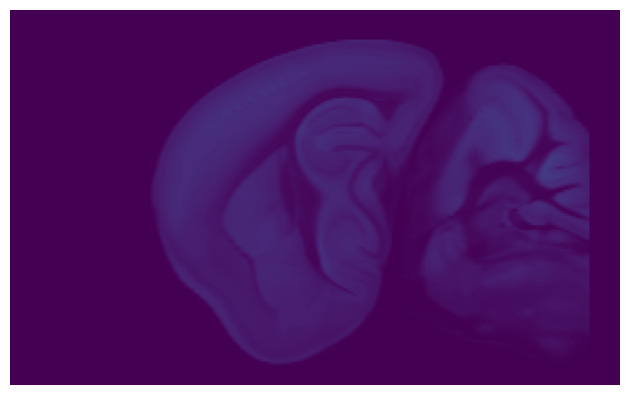

In [15]:
settings = VolumeSettings(
    orientation=Orientation.SAGITTAL,
    resolution=Resolution.MICRONS_50,
    offset=70,
    pitch=0,
    yaw=20,
    shape=(264, 160, 228),
)

image_center = np.array(
    [
        (settings.shape[0] - 1) // 2 + 1 - settings.offset,
        (settings.shape[1] - 1) // 2,
        (settings.shape[2] - 1) // 2,
    ]
)

z_normal = compute_normal_euler(settings, normal=[0, 0, 1])
point1 = image_center - z_normal * 200
point2 = image_center + z_normal * 200

box = vedo.Box(pos=(0, volume.shape[0], 0, volume.shape[1], 0, volume.shape[2]))
intersections = box.intersect_with_line(point1, point2)

distance_point1 = euclidean(intersections[0], image_center)
distance_point2 = euclidean(intersections[1], image_center)

image = VolumeSlicer(volume=volume).slice(
    settings, normal_function=compute_normal_euler
)

# image = np.pad(image, [(0, 0), (abs(round(distance_point1 - distance_point2)), 0)])

# image[:, (image.shape[1] - 1) // 2] = 2000
# image[(image.shape[0] - 1) // 2] = 2000

imshow(image, vmin=0, vmax=2000)

In [8]:
image.shape

(160, 306)

In [5]:
distance_point1

120.2520885776776

In [6]:
distance_point2

122.38044317517613

In [7]:
show(
    [
        *axes,
        vedo.Arrow(image_center, image_center + z_normal * 100, s=0.2),
        vedo.Arrow(
            image_center, image_center + compute_normal_euler(settings) * 100, s=0.2
        ),
    ],
    camera=coronal_camera,
)